# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [155]:
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import time
from itertools import chain
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [156]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
df = df.convert_dtypes()

In [157]:
print('DataFrame Shape: ' + str(df.shape))
print('Missing data:')
print(df.isnull().sum())
df.head()


DataFrame Shape: (41188, 21)
Missing data:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<Figure size 1500x400 with 0 Axes>

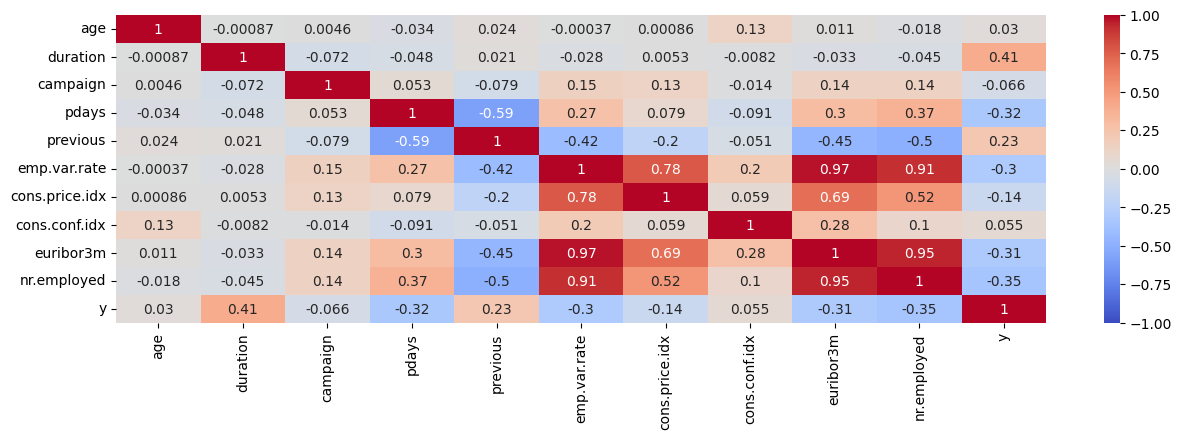

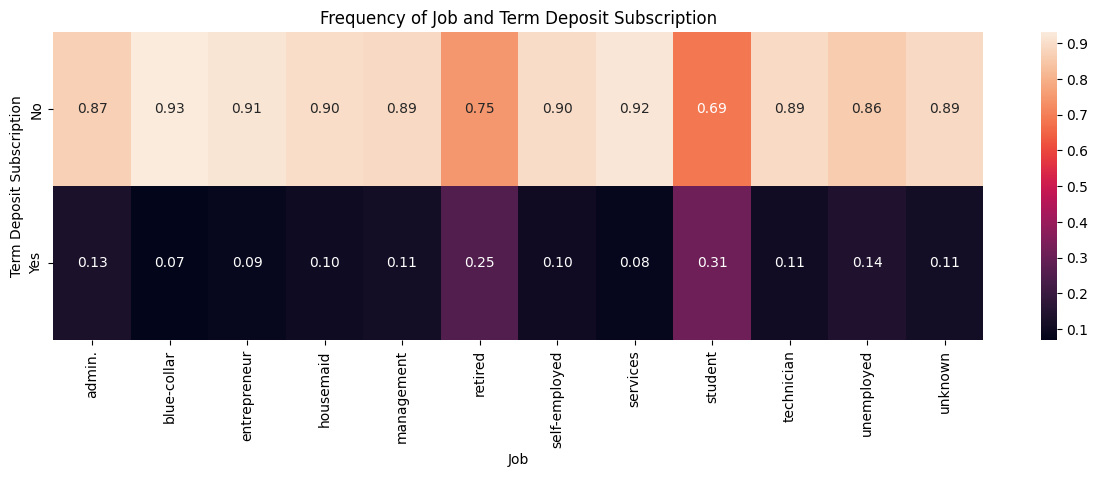

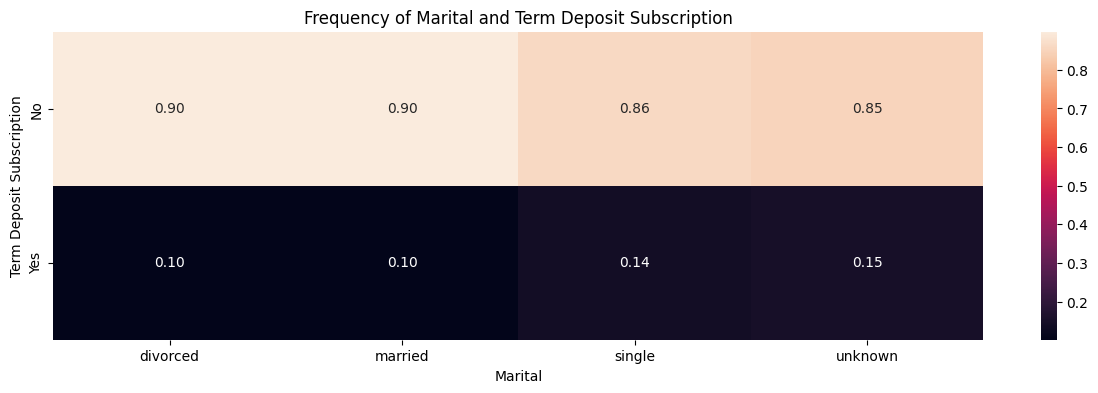

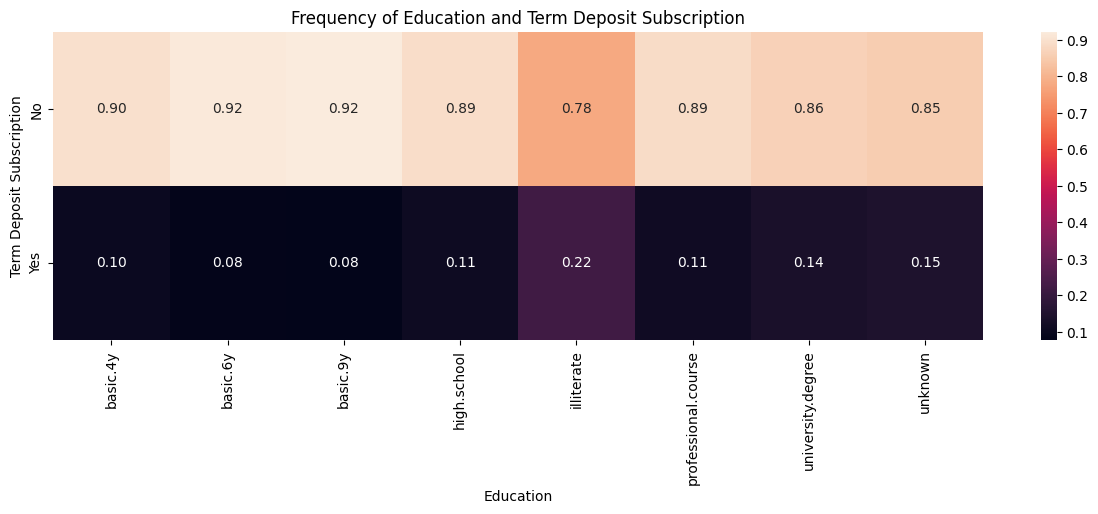

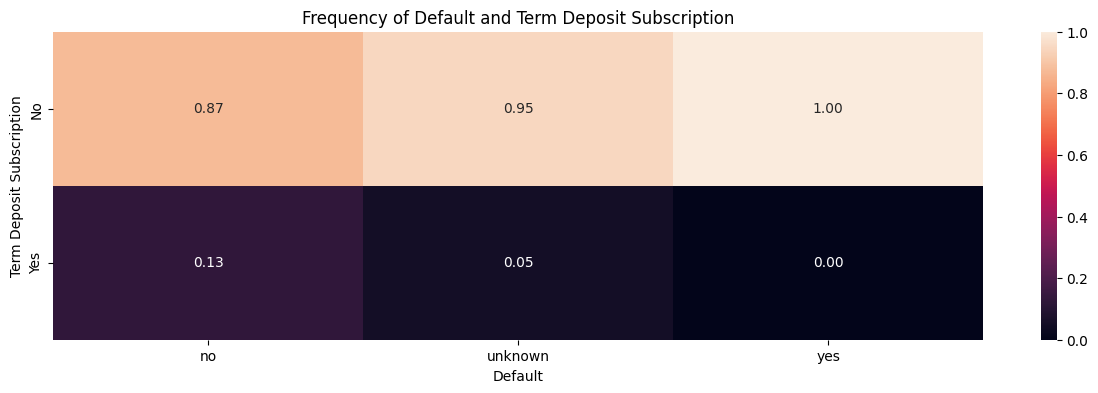

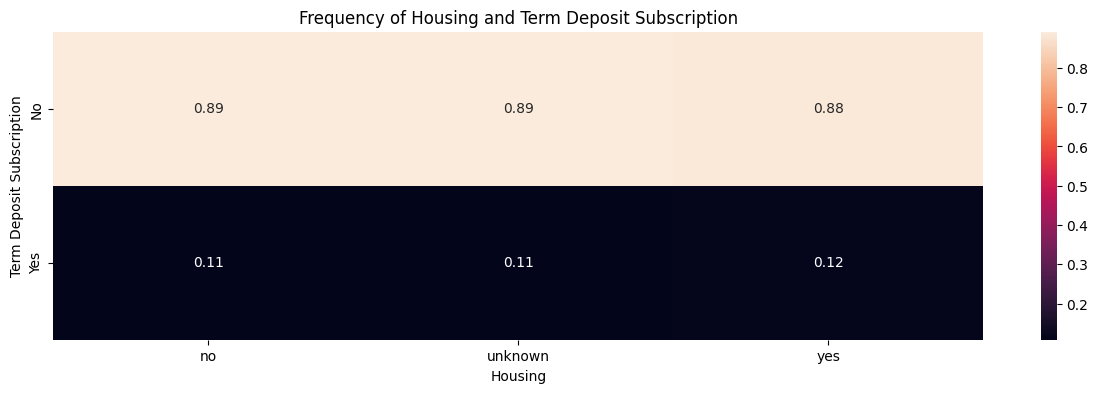

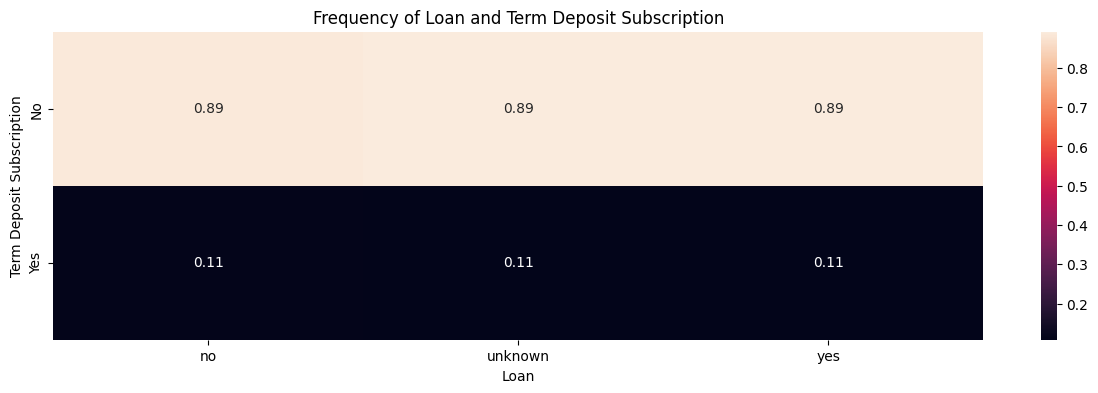

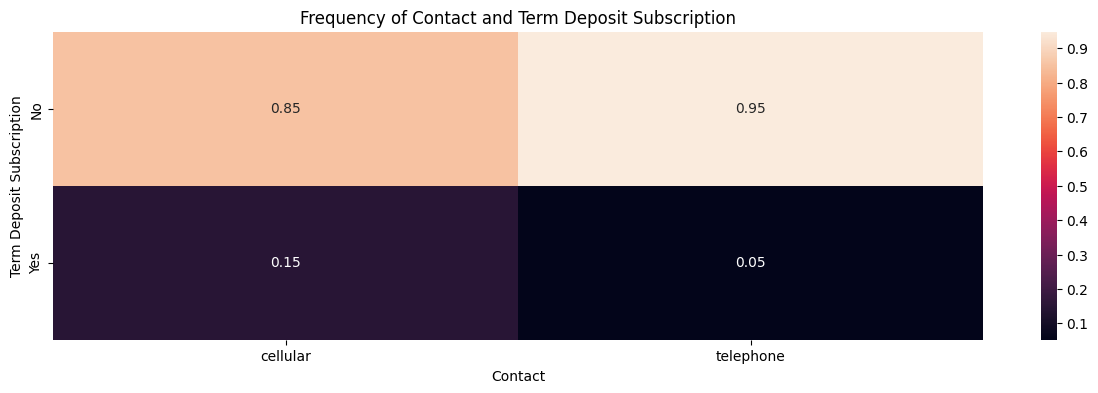

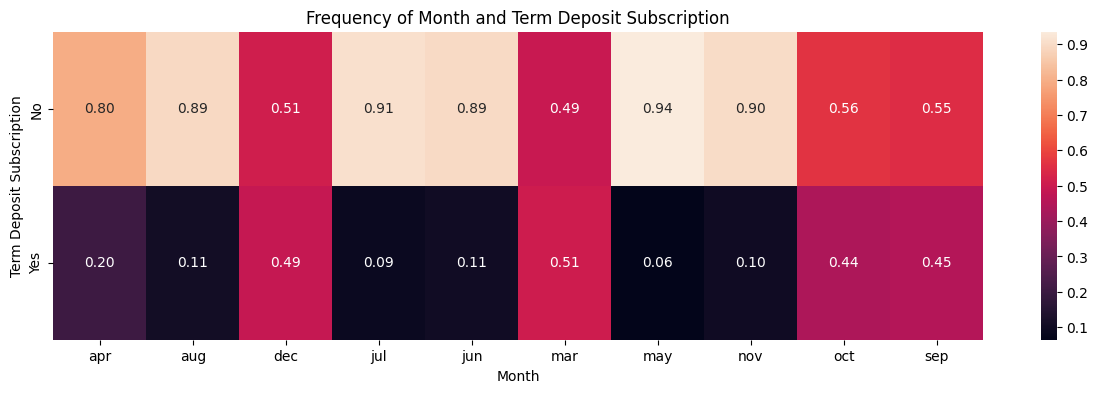

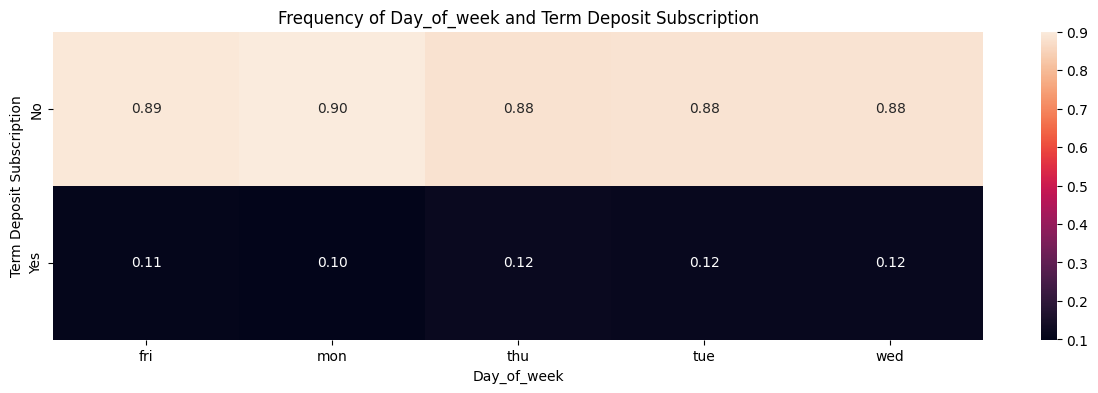

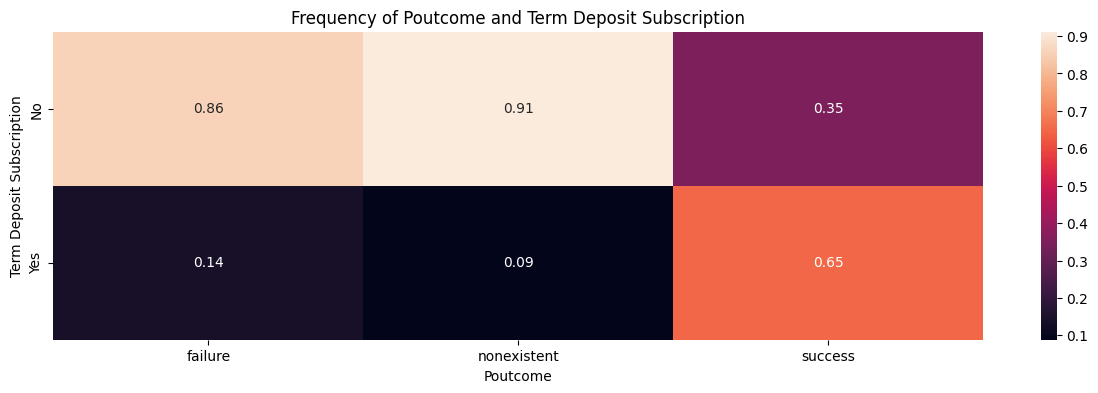

In [158]:
def generate_heat_maps(columns):
  for column in columns:
    plt.figure(figsize=(15,4))
    crosstab = pd.crosstab(df['y'].replace({ 'no': 'No', 'yes': 'Yes' }), df[column], normalize='columns')
    heat_map = sns.heatmap(crosstab, annot=True, fmt='.2f')
    heat_map.set(xlabel=column.capitalize(), ylabel='Term Deposit Subscription', title='Frequency of {0} and Term Deposit Subscription'.format(column.capitalize()))

plt.figure(figsize=(15,4))
#sns.pairplot(df.replace({ 'no': '0', 'yes': '1' }), hue='y')
categorical_columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome' ]
numerical_columns = [ 'age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' ]
plt.figure(figsize=(15,4))
sns.heatmap(df[numerical_columns + [ 'y' ]].replace({ 'no': '0', 'yes': '1' }).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
generate_heat_maps(categorical_columns)

**Conclusions**: We can see that the target is mostly correlated with:

**Numerical Columns**: duration, number of employees, number of days that passed by after the client was last contacted, and euribor 3 month rate.
**Categorical Columns**: There are high correlations with all categorical columns (job, marital, education, default, housing, loan, contact, month, day of week, and p outcome),

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The **business objective** is to enhance the efficiency of directed campaigns for long-term deposit subscriptions by minimizing contact volume. This will be achieved using a dataset from a Portuguese bank, encompassing 79,354 contacts across 17 campaigns conducted between May 2008 and November 2010. These campaigns offered an attractive long-term deposit product. The dataset includes numerous attributes for each contact, along with a binary indicator of campaign success. The overall success rate within the dataset is 8%, with 6,499 successful subscriptions.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [159]:
df['y'] = df['y'].map(dict(yes=1, no=0))

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [160]:
X = df[categorical_columns + numerical_columns]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [161]:
results = []
pd.set_option('display.max_rows', None)
def run_model(name, model, X_train, X_test, y_train, y_test):
  train_time = time.time()
  model.fit(X_train, y_train)
  train_time = (time.time() - train_time)
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)
  train_accuracy = accuracy_score(y_train, pred_train)
  test_accuracy = accuracy_score(y_test, pred_test)
  train_recall = recall_score(y_train, pred_train)
  test_recall = recall_score(y_test, pred_test)
  train_precision = precision_score(y_train, pred_train)
  test_precision = precision_score(y_test, pred_test)
  train_f1 = f1_score(y_train, pred_train)
  test_f1 = f1_score(y_test, pred_test)
  train_r2 = r2_score(y_train, pred_train)
  test_r2 = r2_score(y_test, pred_test)
  train_mse = mean_squared_error(y_train, pred_train)
  train_mae = mean_absolute_error(y_train, pred_train)
  test_mse = mean_squared_error(y_test, pred_test)
  test_mae = mean_absolute_error(y_test, pred_test)
  lift = 0
  cm = confusion_matrix(y_test, pred_test)
  tn, fp, fn, tp = cm.ravel()
  actual_positives = tp + fn
  predicted_positives = tp + fp
  total_samples = tn + fp + fn + tp
  if (predicted_positives > 0) and (actual_positives > 0):
    baseline_rate = actual_positives / total_samples
    model_rate = tp / predicted_positives
    lift = model_rate / baseline_rate
  else:
    lift = 0
  coefs = []

  feature_names = X_train.columns.to_list()
  if hasattr(model, 'named_steps'):
    if 'transformer' in model.named_steps:
      transformer = model.named_steps['transformer']
      feature_names = transformer.get_feature_names_out()
      if 'logreg' in model.named_steps:
        for index, coef in enumerate(model.named_steps['logreg'].coef_[0]):
          try:
            numerical_column_index = numerical_columns.index(feature_names[index])
            if hasattr(transformer, 'standardscaler'):
              coef = coef / transformer['standardscaler'].scale_[numerical_column_index] / df[feature_names[index]].std()
          except ValueError:
            pass
          coefs.append({ 'Feature Name': feature_names[index], 'Coefficient': coef })
        display(pd.DataFrame(coefs).sort_values(by='Coefficient'))

  best_params = ''
  if hasattr(model, 'best_params_'):
    best_params = str(model.best_params_)
  result = { 'Model': name, 'Train Time': train_time, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'Lift': lift, 'Train Recall': train_recall, 'Test Recall': test_recall, 'Train Precision': train_precision, 'Test Precision': test_precision, 'Train F1': train_f1, 'Test F1': test_f1, 'Train R2': train_r2, 'Test R2': test_r2, 'Train MSE': train_mse, 'Test MSE': test_mse, 'Train MAE': train_mae, 'Test MAE': test_mae, 'Best Parameters': best_params }
  results.append(result)

  if hasattr(model, 'named_steps') and 'decisiontree' in model.named_steps:
    plt.figure(figsize=(20, 10))
    plot_tree(model.named_steps['decisiontree'], feature_names=feature_names, filled=True, rounded=True, fontsize=10, max_depth=2)
    plt.title("Decision Tree from Random Forest")
    plt.show()

X = df[categorical_columns + numerical_columns]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [162]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('nb', GaussianNB())])
run_model('Naive Bayes, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
display(pd.DataFrame(results))
# Best Test Accuracy Score: 0.817310





,Model,Train Time,Train Accuracy,Test Accuracy,Lift,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Best Parameters
0,"Naive Bayes, One Hot Encoder, Standard Scaler",0.431033,0.819545,0.81731,2.976233,0.657516,0.64308,0.340464,0.347191,0.448628,0.45093,-0.819336,-0.772893,0.180455,0.18269,0.180455,0.18269,


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [163]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('logreg', LogisticRegression())])
run_model('Logistic Regression, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.907259

,Feature Name,Coefficient
58,standardscaler__emp.var.rate,-2.514889
41,onehotencoder__month_may,-0.798461
39,onehotencoder__month_jun,-0.695220
50,onehotencoder__poutcome_failure,-0.694942
34,onehotencoder__contact_telephone,-0.690224
42,onehotencoder__month_nov,-0.684342
25,onehotencoder__default_unknown,-0.494332
35,onehotencoder__month_apr,-0.401539
31,onehotencoder__loan_unknown,-0.313890
28,onehotencoder__housing_unknown,-0.313890


**Conclusion**: Based on the coeficcients the most important features are the month of march, duration, consumer price index, and employment variation rate.

### Problem 9: Score the Model

What is the accuracy of your model?

In [164]:
pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)

,Model,Train Time,Train Accuracy,Test Accuracy,Lift,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Best Parameters
1,"Logistic Regression, One Hot Encoder, Standard...",1.751901,0.912534,0.907259,5.719732,0.426746,0.408949,0.670081,0.667233,0.521421,0.507097,0.118176,0.100006,0.087466,0.092741,0.087466,0.092741,
0,"Naive Bayes, One Hot Encoder, Standard Scaler",0.431033,0.819545,0.817310,2.976233,0.657516,0.643080,0.340464,0.347191,0.448628,0.450930,-0.819336,-0.772893,0.180455,0.182690,0.180455,0.182690,


**Conclusion**: The Logistic Regression has a high test accuracy and lift compared to our base model.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [165]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('knn', KNeighborsClassifier())])
run_model('KNN Classifier, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.895363

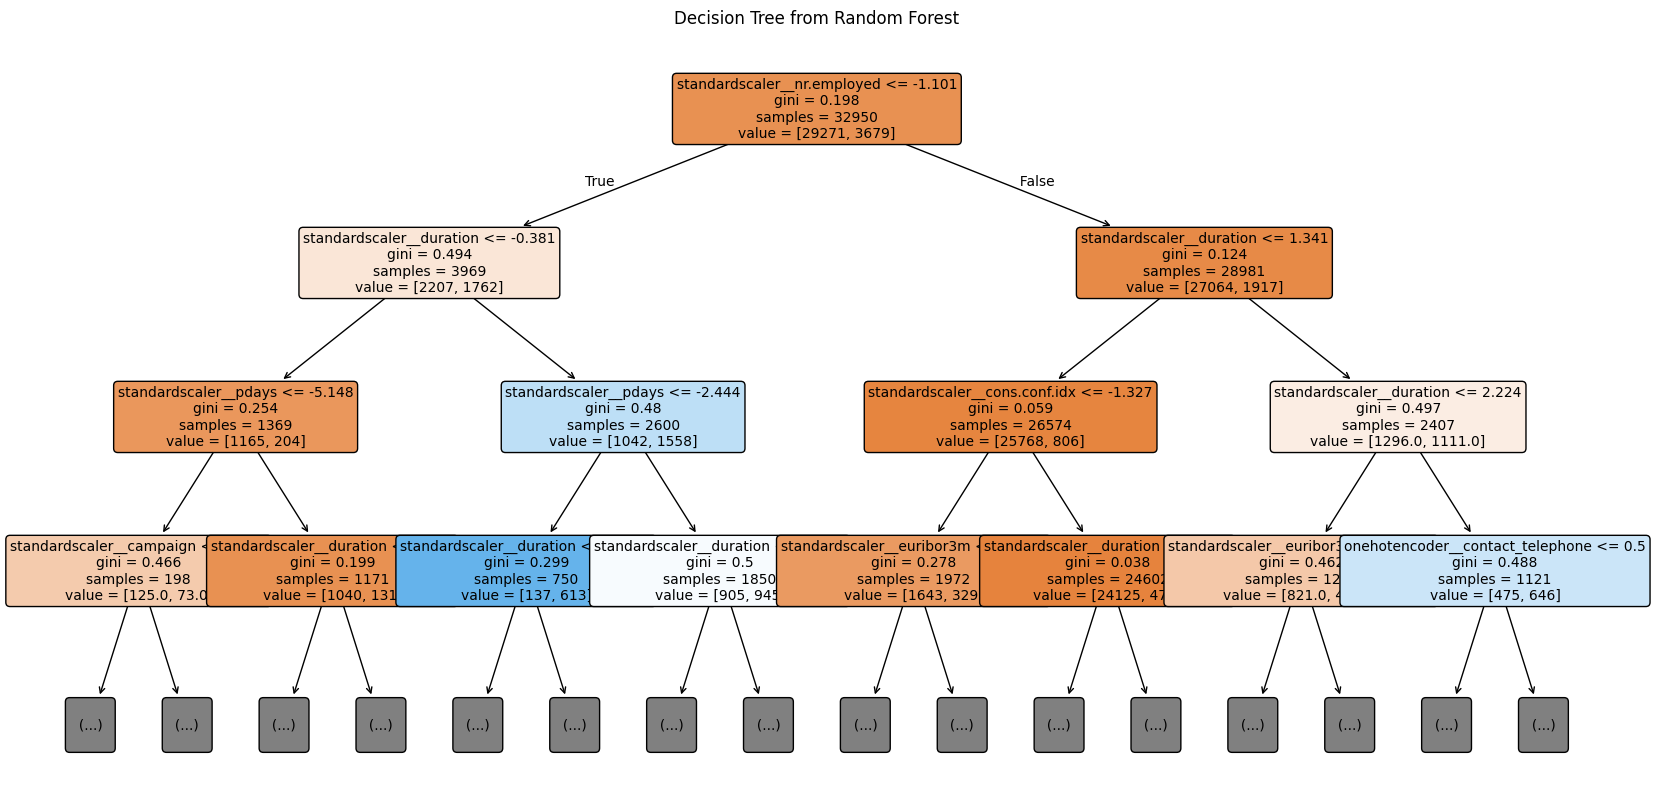

In [166]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('decisiontree', DecisionTreeClassifier())])
run_model('Decision Tree Classifier, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.889779

**Conclusion**: Based on the plot tree we can see that the most important features are number of employees, last contact duration, and number of days that passed by after the client was last contacted.

In [167]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='linear'))])
run_model('Support Vector Machine Linear, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.899854

In [168]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='poly'))])
run_model('Support Vector Machine Polygonal, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.903375

In [169]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='rbf'))])
run_model('Support Vector Machine RBF, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
print(pipe.named_steps['svm']._gamma)
# Best Test Accuracy Score: 0.905924

0.05431034482758621


In [171]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='sigmoid'))])
run_model('Support Vector Machine Sigmoid, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.863074

In [172]:
display(pd.DataFrame(results))

,Model,Train Time,Train Accuracy,Test Accuracy,Lift,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Best Parameters
0,"Naive Bayes, One Hot Encoder, Standard Scaler",0.431033,0.819545,0.817310,2.976233,0.657516,0.643080,0.340464,0.347191,0.448628,0.450930,-0.819336,-0.772893,0.180455,0.182690,0.180455,0.182690,
1,"Logistic Regression, One Hot Encoder, Standard...",1.751901,0.912534,0.907259,5.719732,0.426746,0.408949,0.670081,0.667233,0.521421,0.507097,0.118176,0.100006,0.087466,0.092741,0.087466,0.092741,
2,"KNN Classifier, One Hot Encoder, Standard Scaler",0.288440,0.929196,0.895363,4.891481,0.556129,0.416233,0.745084,0.570613,0.636887,0.481348,0.286157,-0.015438,0.070804,0.104637,0.070804,0.104637,
3,"Decision Tree Classifier, One Hot Encoder, Sta...",0.484668,1.000000,0.890265,4.544691,1.000000,0.521332,1.000000,0.530159,1.000000,0.525708,1.000000,-0.064914,0.000000,0.109735,0.000000,0.109735,
4,"Support Vector Machine Linear, One Hot Encoder...",43.676566,0.906131,0.899854,5.510777,0.322642,0.318418,0.663870,0.642857,0.434242,0.425887,0.053615,0.028148,0.093869,0.100146,0.093869,0.100146,
5,"Support Vector Machine Polygonal, One Hot Enco...",30.200500,0.929530,0.903375,5.583805,0.481653,0.369407,0.810242,0.651376,0.604160,0.471448,0.289523,0.062310,0.070470,0.096625,0.070470,0.096625,
6,"Support Vector Machine RBF, One Hot Encoder, S...",26.567273,0.923854,0.905924,5.660688,0.465887,0.398543,0.759079,0.660345,0.577396,0.497080,0.232305,0.087048,0.076146,0.094076,0.076146,0.094076,
7,"Support Vector Machine Sigmoid, One Hot Encode...",27.429788,0.865948,0.863074,3.471839,0.390323,0.370447,0.397784,0.405006,0.394018,0.386957,-0.351498,-0.328786,0.134052,0.136926,0.134052,0.136926,


**Conclusion**: The logistic regression has the highest test accuracy and Lift. The second best model would be the SVM with RBF. The model with the least test accuracy and lift is our base model. The decision tree has a train accuracy of 1 meaning that it's overfitting the model.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

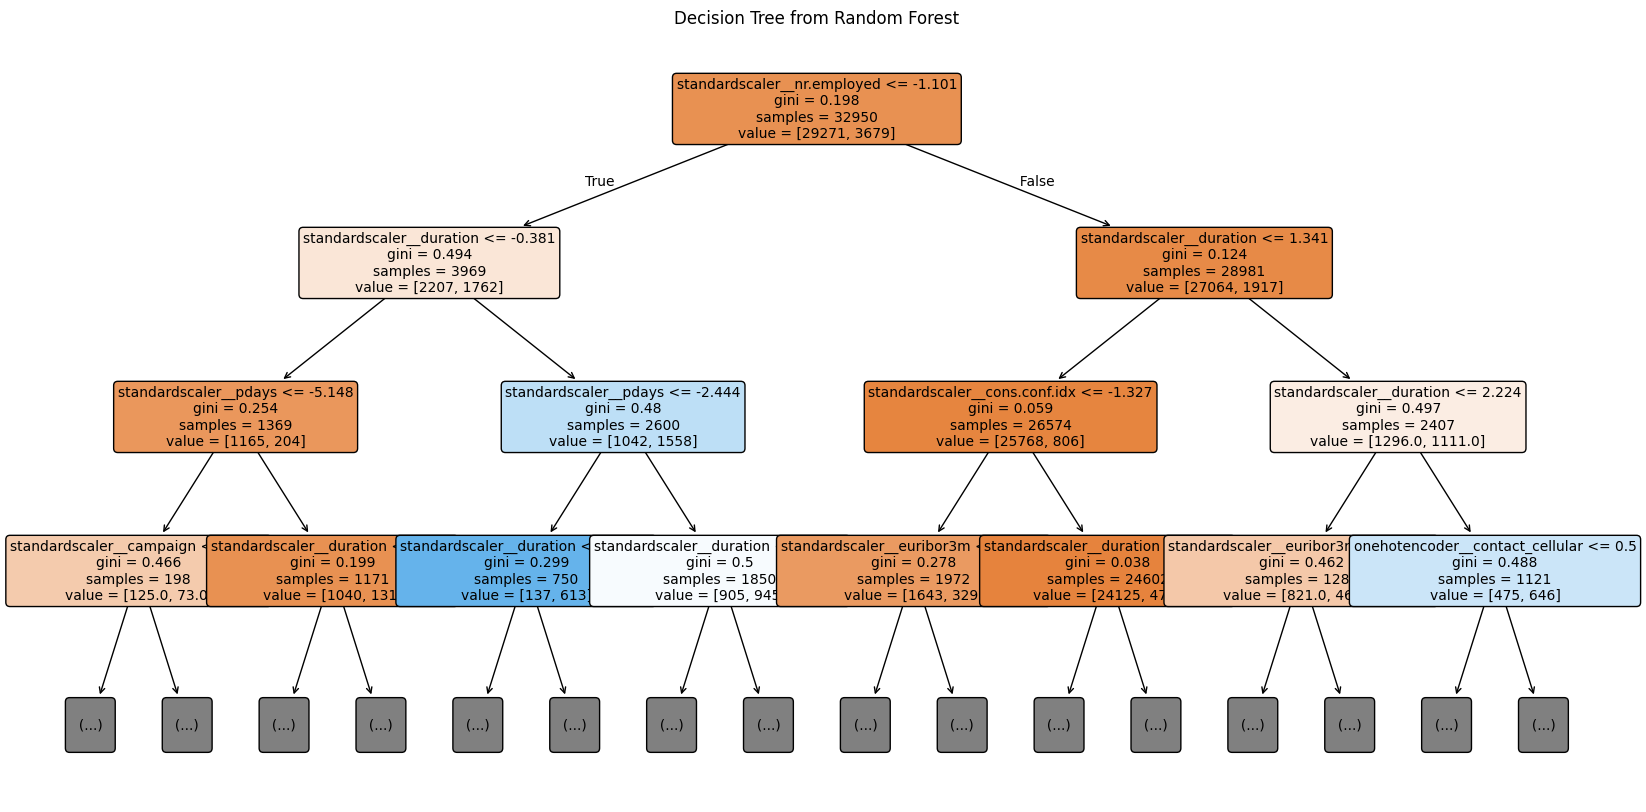

In [173]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('decisiontree', DecisionTreeClassifier(max_depth=5))])
run_model('Decision Tree Classifier with Max Depth 5, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.911629

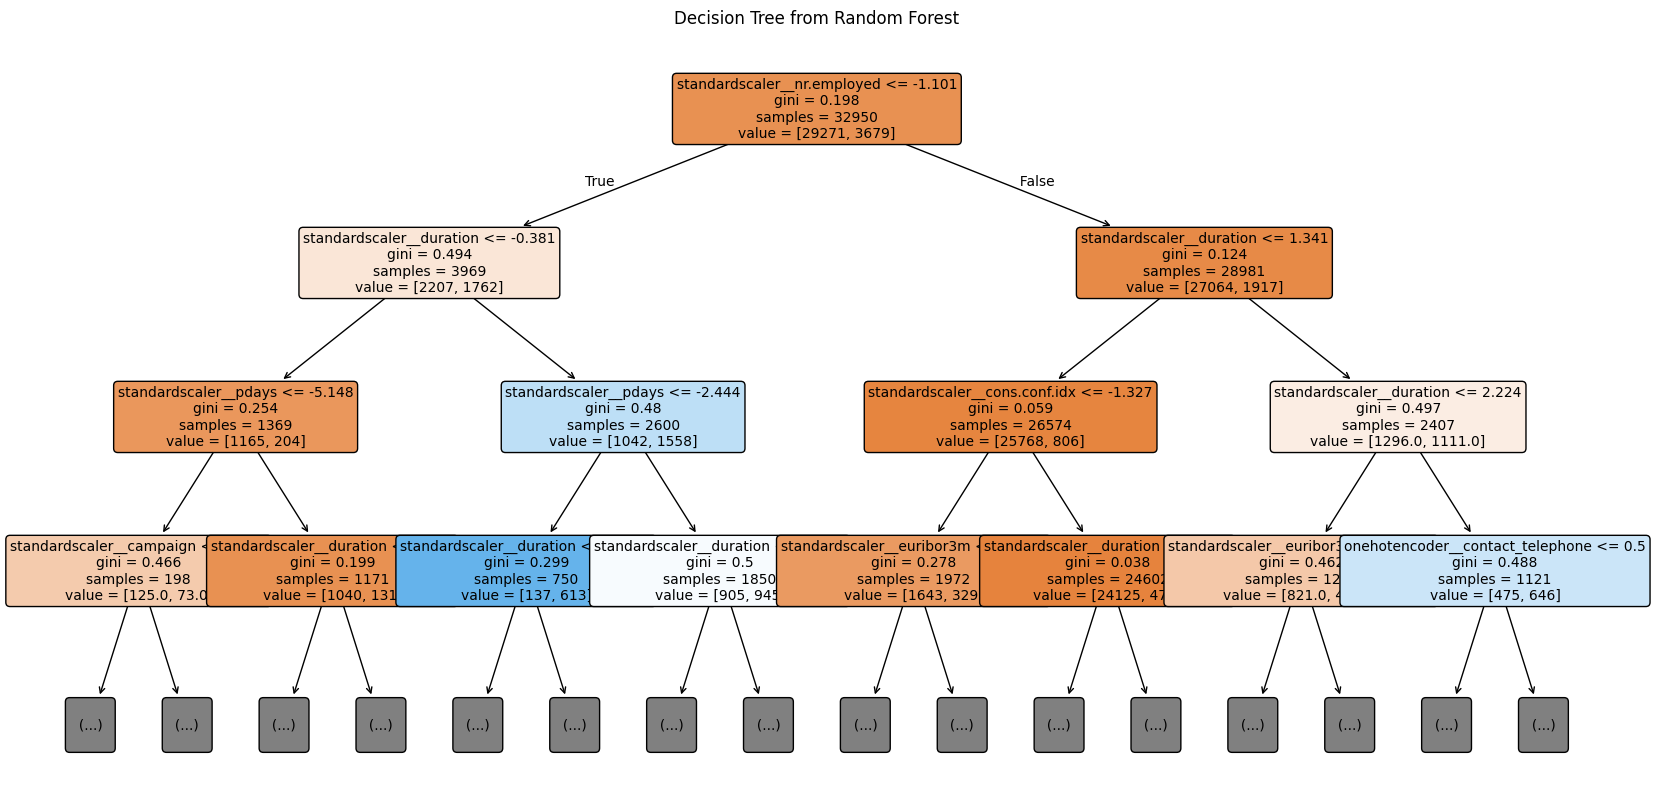

In [174]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('decisiontree', DecisionTreeClassifier(max_depth=10))])
run_model('Decision Tree Classifier with Max Depth 10, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.904588

In [175]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='rbf', gamma=0.1))])
#grid = GridSearchCV(pipe, {'svm__gamma': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08] })
run_model('Support Vector Machine Linear Kernel Gamma 0.1, One Hot Encoder', pipe, X_train, X_test, y_train, y_test)
# Best Test Accuracy Score: 0.905924 Lift:	5.660688

In [176]:
display(pd.DataFrame(results).sort_values(by='Lift', ascending=False))

,Model,Train Time,Train Accuracy,Test Accuracy,Lift,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Best Parameters
1,"Logistic Regression, One Hot Encoder, Standard...",1.751901,0.912534,0.907259,5.719732,0.426746,0.408949,0.670081,0.667233,0.521421,0.507097,0.118176,0.100006,0.087466,0.092741,0.087466,0.092741,
6,"Support Vector Machine RBF, One Hot Encoder, S...",26.567273,0.923854,0.905924,5.660688,0.465887,0.398543,0.759079,0.660345,0.577396,0.497080,0.232305,0.087048,0.076146,0.094076,0.076146,0.094076,
5,"Support Vector Machine Polygonal, One Hot Enco...",30.200500,0.929530,0.903375,5.583805,0.481653,0.369407,0.810242,0.651376,0.604160,0.471448,0.289523,0.062310,0.070470,0.096625,0.070470,0.096625,
8,"Decision Tree Classifier with Max Depth 5, One...",0.422056,0.919150,0.911629,5.542356,0.569176,0.534860,0.659943,0.646541,0.611208,0.585421,0.184879,0.142415,0.080850,0.088371,0.080850,0.088371,
10,Support Vector Machine Linear Kernel Gamma 0.1...,46.875905,0.934476,0.904831,5.523763,0.536015,0.411030,0.813531,0.644372,0.646240,0.501906,0.339397,0.076446,0.065524,0.095169,0.065524,0.095169,
4,"Support Vector Machine Linear, One Hot Encoder...",43.676566,0.906131,0.899854,5.510777,0.322642,0.318418,0.663870,0.642857,0.434242,0.425887,0.053615,0.028148,0.093869,0.100146,0.093869,0.100146,
9,"Decision Tree Classifier with Max Depth 10, On...",0.580068,0.941093,0.904831,5.235660,0.664039,0.507804,0.776048,0.610763,0.715688,0.554545,0.406100,0.076446,0.058907,0.095169,0.058907,0.095169,
2,"KNN Classifier, One Hot Encoder, Standard Scaler",0.288440,0.929196,0.895363,4.891481,0.556129,0.416233,0.745084,0.570613,0.636887,0.481348,0.286157,-0.015438,0.070804,0.104637,0.070804,0.104637,
3,"Decision Tree Classifier, One Hot Encoder, Sta...",0.484668,1.000000,0.890265,4.544691,1.000000,0.521332,1.000000,0.530159,1.000000,0.525708,1.000000,-0.064914,0.000000,0.109735,0.000000,0.109735,
7,"Support Vector Machine Sigmoid, One Hot Encode...",27.429788,0.865948,0.863074,3.471839,0.390323,0.370447,0.397784,0.405006,0.394018,0.386957,-0.351498,-0.328786,0.134052,0.136926,0.134052,0.136926,


**Conclusions**: We tried to improve the base models with the following changes:


1.   Limited the branch depth of the Decision Tree to 5 and 10 levels to reduce overfitting and see if it will improve accuracy. The test accuracy improved and it is now best of all models, but still falls behind the SVM RBF model in terms of lift.
2.   Used grid search to optimize the gamma hyperparameter on the SVM RBF model. But it did not improve over the standard parameter.

